In [38]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

2586.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2593.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2600.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2607.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.rcParams['text.usetex'] = False

In [23]:
def unfuck(prediction):
    fucked_index = prediction.find("}")
    if fucked_index >= 0:
        try:
            json_data = json.loads(prediction[0:fucked_index+1])
            unfucked_tags = json_data['tags']
            return False, unfucked_tags
        except Exception as fuckedup:
            return True, None
    else:
        return True, None
    
    return fucked

song_ids = []
with open('data/all_songs.json', 'rt', encoding='utf8') as infile:
    songs = json.load(infile)
    for song in songs:
        song_ids.append(song['GeniusId'])

with open('predictions_evaluation.json', 'rt', encoding='utf8') as infile:
    songs = json.load(infile) 
    for song in songs:
        if(song['GeniusId'] in song_ids):
            songs.remove(song)

        if('PredictedTags' not in song or song['PredictedTags'] == None):
            song['WasFucked'] = True
            is_fucked, tags = unfuck(song['RawPrediction'])
            if is_fucked:
                song['IsFucked'] = True 
            else:
                song['IsFucked'] = False
                song['PredictedTags'] = tags
        else:
            song['WasFucked'] = True
            song['IsFucked'] = False

    with open('predictions_evaluation_unfucked.json', 'wt', encoding='utf8') as outfile:
        json.dump(songs, outfile, indent=2)

In [13]:
data = pd.read_json('predictions_evaluation_unfucked.json', orient='records')
data.set_index('GeniusId', inplace=True)
data.info()

tag_counts = data['LastFMTags'].explode().value_counts().reset_index()
tag_counts.columns = ['Tag', 'Count']
tag_counts.set_index('Tag', inplace=True)
tag_counts.info()
tag_counts.to_csv('tags.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 1046647 to 1821834
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ArtistId           25000 non-null  int64 
 1   PrimaryArtistName  25000 non-null  object
 2   FeaturedArtists    25000 non-null  object
 3   Title              25000 non-null  object
 4   Lyrics             25000 non-null  object
 5   ArtistNames        25000 non-null  object
 6   HasCompleteLyrics  25000 non-null  bool  
 7   LastFMTags         25000 non-null  object
 8   RawPrediction      25000 non-null  object
 9   PredictedTags      25000 non-null  object
 10  WasFucked          25000 non-null  bool  
 11  IsFucked           25000 non-null  bool  
dtypes: bool(3), int64(1), object(8)
memory usage: 2.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4342 entries, rap to hardcore hiphop
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  ---------

In [11]:
tag_alias = json.load(open('tag_alias.json'))  
tags = pd.read_csv('tags_manual_removal.csv', index_col='Tag')

for alias, sub_tags in tag_alias.items():
    count = data[data['LastFMTags'].apply(lambda x: any(tag in sub_tags for tag in x))].shape[0]
    for tag in sub_tags:
        tags.drop(tag, inplace=True)
    
    tags.loc[alias] = [count]

tags.to_csv('tags_cleaned.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


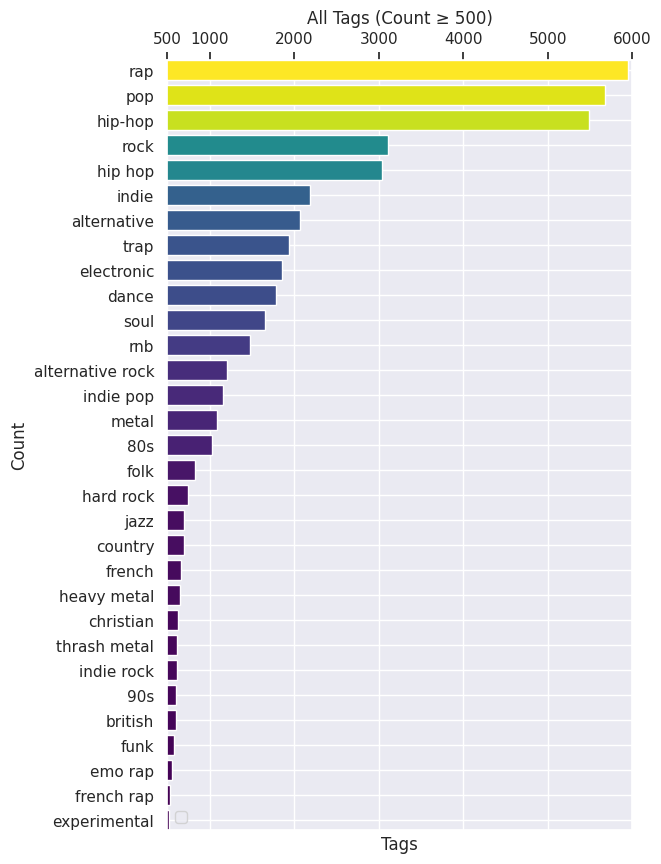

In [12]:
tags = pd.read_csv('tags_cleaned.csv', index_col='Tag')
to_show = tags[tags['Count'] >= 500].sort_values(by=['Count'], ascending=True)
sns.set_theme(style='whitegrid')
sns.set_color_codes('pastel')
sns.set()
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(6)

cmap = plt.get_cmap('viridis')
rescale = lambda y: (y - to_show.Count.min()) / (to_show.Count.max() - to_show.Count.min())

ax.barh(to_show.index, to_show['Count'], color=cmap(rescale(to_show.Count)))
ax.set_title('All Tags (Count ≥ 500)')
ax.set_xlabel('Tags')
ax.set_ylabel('Count')
ax.set_xlim(to_show.Count.min(), 6000)

ticks = [500, 1000, 2000, 3000, 4000, 5000, 6000]

ax.set_xticks(ticks)
ax.xaxis.tick_top()
ax.margins(0,0)
plt.legend()
plt.show()

In [10]:
valid_tag_names = [x for x, _ in tags.iterrows()]
data['CleanedPredictedTags'] = data.apply(lambda row: [x for x in row.PredictedTags if x in valid_tag_names] or None, axis=1)
for i, row in data[data['CleanedPredictedTags'].isna()].iterrows():
    print(f"{i}: no tags after clean, initial: {row.PredictedTags}")

data.info()

893058: no tags after clean, initial: ['j-rock', 'visual kei']
977775: no tags after clean, initial: ['j-rock', 'visual kei']
1410052: no tags after clean, initial: ['j-rock', 'visual kei']
987872: no tags after clean, initial: ['j-rock', 'visual kei']
1753206: no tags after clean, initial: ['j-rock', 'visual kei']
943173: no tags after clean, initial: ['j-rock', 'visual kei']
989371: no tags after clean, initial: ['j-rock', 'visual kei']
8388301: no tags after clean, initial: ['j-rock', 'anime', 'opening']
965793: no tags after clean, initial: ['j-rock', 'visual kei']
1153632: no tags after clean, initial: ['j-rock', 'visual kei']
7935796: no tags after clean, initial: ['j-rock', 'visual kei']
1324619: no tags after clean, initial: ['j-rock', 'visual kei']
6956925: no tags after clean, initial: ['j-rock', 'visual kei']
1259885: no tags after clean, initial: ['j-rock', 'visual kei']
986935: no tags after clean, initial: ['j-rock', 'visual kei']
317212: no tags after clean, initial: ['m